## Load modules

In [56]:
import pandas as pd
import os # Check folder contents
import docx2txt # Import word files
import openpyxl # Save files to Excel
import random # For thumbnail
from PIL import Image # Resizing thumbnail

## Load/Prepare Data Files

### Set Locations

In [57]:
script_loc = "./Scripts/"
images_loc = "./Images/"
set_scripts_loc = "./Set Scripts/"
audio_loc = "./Audio/"
video_loc = "./Video/"

# Get the Intro
intro = docx2txt.process(set_scripts_loc + 'Intro.docx')

# Get the Description
description = docx2txt.process(set_scripts_loc + 'Description.docx')
    
# Get the Outro
outro = docx2txt.process(set_scripts_loc + 'Outro.docx')

### Load the dataframe of information

In [58]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')

In [59]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_audio = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "No")]

## Create Any Necessary Audio Files

In [60]:
# We only do this if audio is needed
if need_audio.shape[0] > 0:
  # These library only needed here
  import pyttsx3 # Text to speech
  
  # Initialise the engine and set some parameters
  engine = pyttsx3.init()

  # Set the voice
  engine.setProperty('voice',
                     'HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-GB_HAZEL_11.0')
  
  # Set the talking rate
  rate = engine.getProperty('rate')
  engine.setProperty('rate', rate-50)

  # Create figure filepaths
  figure_scripts = list(need_audio.iloc[:,1].values + '.docx')

  # Now want to loop through the figures, getting the script, the figures name and then
  # saving the audio before changing the value in the Excel file for needs audio to yes.
  for figure in figure_scripts:
    
    # Grab the script
    my_text = docx2txt.process(script_loc + figure)
    
    # Alter the script
    my_text = intro + my_text + outro 
    
    # Return the figure's name
    figure_name = os.path.splitext(figure)[0]
    
    # Create the audio location
    audio_script_loc = audio_loc + figure_name + ".mp3" 
    
    # Save the file
    engine.save_to_file(my_text, audio_script_loc)
    
    # Convert the No to Yes in needs audio column
    historical_figures_list.iloc[(historical_figures_list.Name == figure_name),4] = "Yes"
    
  # Once all done stop the engine and then overwrite the Excel file
  engine.setProperty('rate', rate+50)
  engine.runAndWait()
  engine.stop()
  historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## COMMENT OUT - THIS IS FOR MAC WILL ADJUST WHEN ABLE

In [61]:
#import gtts # Speech to text
# make request to google to get synthesis
#tts = gtts.gTTS(my_text, tld= "co.uk")
# save the audio file
#tts.save("hello.mp3")

In [62]:
# play the audio file
# playsound("hello.mp3")

## Check For Images

Next we want to check to see if there are any figures who have images in the Images folder but i have forgot to change the images value to yes

In [63]:
# We grab any that still need images
need_images = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                      (historical_figures_list.AI_Voice_Generated == "Yes") &
                                      (historical_figures_list.Images_Obtained == "No")]

In [64]:
# If there are figures with images needed we will check to see if there are actually images there and then if there
# are we will change the images obtained value to yes.
if need_images.shape[0] > 0:
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + '/' + figure
        
        # If there are any figures where the folder path exists
        if os.path.exists(image_path) == True:
            # Check the number of files and if more than zero. Make changes to document
            if len(os.listdir(image_path + '/')) > 0:
                historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
                historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
                

## Add Video

In [65]:
# We will grab any figures who have a script and audio complete but no video.
need_video = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "No")]

In [66]:
if need_video.shape[0] > 0:
    from moviepy.editor import *
    os.environ["IMAGEIO_FFMPEG_EXE"] = "ffmpeg"
    figure_video = list(need_video.iloc[:,1].values)
    
    for figure in figure_video:
        audio_location = audio_loc + figure + '.mp3'
        image_location = images_loc + figure + '/'
        video_location = video_loc + figure + '.mp4'
        
        audio_clip = AudioFileClip(audio_location)
        audio_duration = audio_clip.duration
        
        number_of_images = len(os.listdir(image_location))
        image_duration = audio_duration / number_of_images
        
        img_names = os.listdir(image_location)

        img = list(image_location + img for img in img_names)

        clips = [ImageClip(m).set_duration(image_duration)
                 for m in img]

        concat_clip = concatenate_videoclips(clips, method="compose")
        
        concat_clip.write_videofile("test.mp4", fps = 24)
        
        video_clip = VideoFileClip("test.mp4")
        
        video_clip.audio = audio_clip
        
        video_clip.write_videofile(video_location)
        
        os.remove("test.mp4")
        
        historical_figures_list.iloc[(historical_figures_list.Name == figure),6] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
Moviepy - Building video ./Video/Marie Curie.mp4.
MoviePy - Writing audio in Marie CurieTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./Video/Marie Curie.mp4



Moviepy - Done !
Moviepy - video ready ./Video/Marie Curie.mp4


## Create Description For Upload

In [67]:
def create_description(string, string_to_replace, figure):
    # Create YouTube description
    modified_string = string.replace(string_to_replace, figure)
    print(modified_string)

In [68]:
def move_video(figure):
    # We want to move the video to the main file directory
    import shutil
    video_location = video_loc + figure + '.mp4'
    shutil.copy2(video_location, "video.mp4")

In [69]:
def create_thumbnail(figure):

    # Set image location
    image_location = images_loc + figure + '/'

    # Return images
    img_names = os.listdir(image_location)
    
    # Select an image at random
    selected_image = image_location + random.choice(img_names)
   
    # This plots the thumbnail so we can see it
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(selected_image)
    imgplot = plt.imshow(img)
    plt.show()
    
    # Now we want to convert the thumbnail into a resized thumbnail.

    # Open the image
    image = Image.open(selected_image)

    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    image.thumbnail(max_image_size)
  
    # creating thumbnail
    image.save('thumbnail.png')

## Youtube Preparation

In [73]:
move_video('Marie Curie')

In [74]:
create_description(description, "[Historical Figure]", 'Marie Curie')

Welcome to Figures in History! In this episode, we delve into the life and legacy of Marie Curie. Join us as we uncover ten key facts about this influential individual who left an indelible mark on history. From their groundbreaking achievements to their remarkable journey, we explore the captivating story behind Marie Curie.

Subscribe to Figures in History for more captivating stories of influential figures who shaped our world. Don't forget to hit the notification bell to stay updated with our latest episodes. We value your input, so leave a comment below and let us know which historical figure you'd like to see featured in future episodes. Your suggestions matter to us!

Join us on this incredible journey through time and discover the inspiring stories that have shaped our world. Remember, it's through understanding the past that we shape a brighter future. So, grab a seat and prepare to be amazed by the remarkable life of Marie Curie.


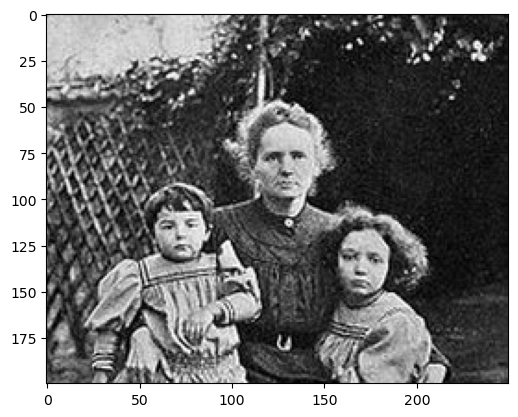

In [85]:
create_thumbnail('Marie Curie')